# Primer intento de Modelo

In [1]:
## Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Cargar dataset

df = pd.read_csv("../data/dataCardsPCAded.csv")

## Train Test

Preparo los grupos de entrenamiento, validación y predicción.
Me quito los de 2025 porque mi intención es predecir esos sin que haya muestra de ellos durante el train.

In [3]:
from sklearn.model_selection import train_test_split

# 1. Separar por año
df_future = df[df['released_year'] == 2025].copy()
df_past = df[df['released_year'] < 2025].copy()

# 2. Definir target
target = 'log_price'

# 3. Separar features y target para cada conjunto
X_past = df_past.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_past = df_past[target]

X_future = df_future.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_future = df_future[target]

# 4. Train-test split sobre datos del pasado
X_train, X_test, y_train, y_test = train_test_split(
    X_past, y_past,
    test_size=0.2,
    random_state=42
)

# 5. Chequeo
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Future shape: {X_future.shape}")

Train shape: (65872, 219), Test shape: (16468, 219), Future shape: (2556, 219)


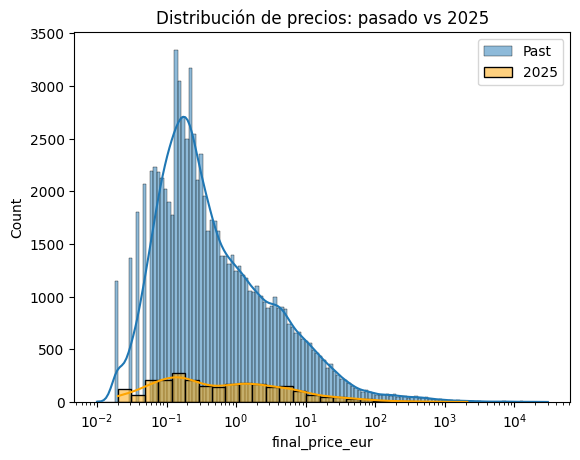

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df[df['released_year'] < 2025]['final_price_eur'], label="Past", kde=True, log_scale=True)
sns.histplot(df[df['released_year'] == 2025]['final_price_eur'], label="2025", kde=True, log_scale=True, color="orange")
plt.legend()
plt.title("Distribución de precios: pasado vs 2025")
plt.show()

## Preparar y Evaluar diferentes modelos

In [5]:

# ------------------------------
# 2. Features a escalar
numeric_features = [
    'cmc', 'edhrec_rank', 'released_year', 'keyword_count',
    'mana_produced_count', 'power_num', 'toughness_num',
    'rarity_labeled', "legal_standard", "legal_pioneer",
    "legal_modern", "legal_legacy", "legal_vintage",
    "legal_commander", "legal_pauper"
]

scaler = MinMaxScaler()
df_past[numeric_features] = scaler.fit_transform(df_past[numeric_features])
df_future[numeric_features] = scaler.transform(df_future[numeric_features])

# ------------------------------
# 3. Split de entrenamiento
X_past = df_past.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_past = df_past[target]
X_future = df_future.drop(columns=['final_price_eur', 'log_price', 'name', "oracle_text"])
y_future = df_future[target]

X_train, X_test, y_train, y_test = train_test_split(X_past, y_past, test_size=0.2, random_state=42)

# ------------------------------
# 4. Dividir por precio
def split_by_price(X, y):
    mask_cheap = y < 4
    return {
        'cheap': (X[mask_cheap], y[mask_cheap]),
        'expensive': (X[~mask_cheap], y[~mask_cheap])
    }

train_split = split_by_price(X_train, y_train)
test_split = split_by_price(X_test, y_test)
future_split = split_by_price(X_future, y_future)



In [ ]:
# ------------------------------
# 5. Modelos y resultados
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge(alpha=1.0)
}

results = []

for name, model in models.items():
    for label in ['cheap', 'expensive']:
        Xtr, ytr = train_split[label]
        Xte, yte = test_split[label]
        Xfu, yfu = future_split[label]
        
        model.fit(Xtr, ytr)
        
        pred_train = model.predict(Xtr)
        pred_test = model.predict(Xte)
        pred_future = model.predict(Xfu)

        mae_train = mean_absolute_error(np.expm1(ytr), np.expm1(pred_train))
        mae_test = mean_absolute_error(np.expm1(yte), np.expm1(pred_test))
        mae_future = mean_absolute_error(np.expm1(yfu), np.expm1(pred_future))

        results.append({
            'model': name,
            'group': label,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'mae_2025': mae_future
        })

# 21m 13s

In [8]:
# ------------------------------
# 6. Resultados
df_results = pd.DataFrame(results)
print(df_results)


              model      group   mae_train    mae_test    mae_2025
0      RandomForest      cheap    0.598720    1.210736    2.151679
1      RandomForest  expensive  207.330347  355.844543  130.184637
2           XGBoost      cheap    0.973037    1.186821    2.107729
3           XGBoost  expensive   93.473559  344.745159  144.977681
4  GradientBoosting      cheap    1.572137    1.556858    2.251192
5  GradientBoosting  expensive  313.743511  376.670786  123.608110
6             Ridge      cheap    1.855382    1.843234    2.347593
7             Ridge  expensive  405.963049  419.002990  134.244355


In [10]:
df_results.to_csv("../data/resultadosModelos_1.csv", index=False)

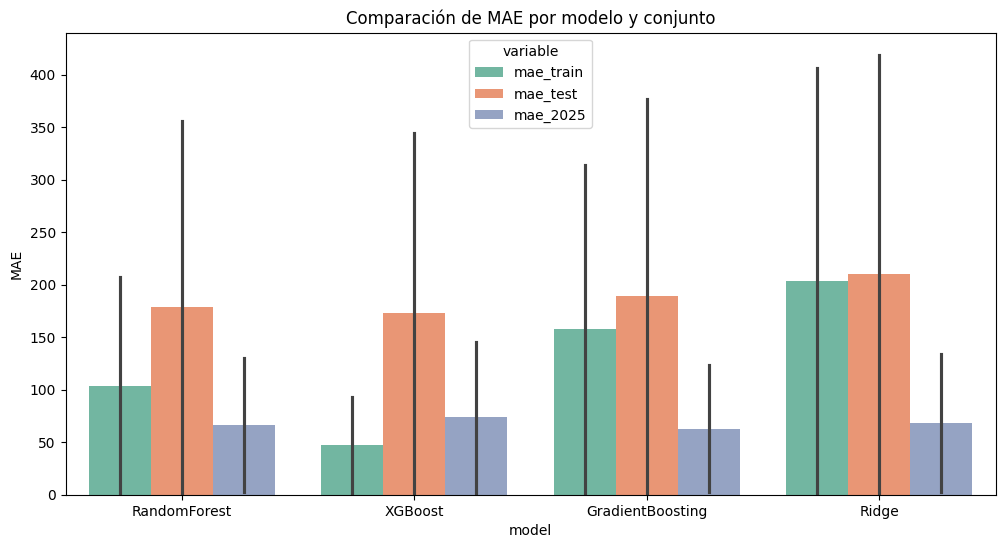

In [9]:
# ------------------------------
# 7. Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.melt(id_vars=['model', 'group'], value_vars=['mae_train', 'mae_test', 'mae_2025']),
            x='model', y='value', hue='variable', palette='Set2')
plt.title("Comparación de MAE por modelo y conjunto")
plt.ylabel("MAE")
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
# }

# grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best MAE: {-grid_search.best_score_}')

In [ ]:
# from sklearn.ensemble import HistGradientBoostingRegressor

# model = HistGradientBoostingRegressor(random_state=42)
# model.fit(X_train, y_train)

# y_train_pred = np.expm1(model.predict(X_train))
# y_test_pred = np.expm1(model.predict(X_test))
# y_2025_pred = np.expm1(model.predict(X_future))

# # Calcular MAE y R2
# from sklearn.metrics import mean_absolute_error, r2_score

# print(f"Train MAE: {mean_absolute_error(np.expm1(y_train), y_train_pred):.2f} Score: {r2_score(np.expm1(y_train), y_train_pred):.3f}")
# print(f"Test MAE: {mean_absolute_error(np.expm1(y_test), y_test_pred):.2f} Score: {r2_score(np.expm1(y_test), y_test_pred):.3f}")
# print(f"2025 MAE: {mean_absolute_error(np.expm1(y_future), y_2025_pred):.2f} Score: {r2_score(np.expm1(y_future), y_2025_pred):.3f}")

## Pipeline 
nada de paiplain, esto es un pipeline

In [ ]:
# # Numéricas continuas (ajusta según las que tengas)
# numeric_features = [
#     'cmc',
#     'edhrec_rank',
#     'released_year',
#     'keyword_count',
#     'mana_produced_count',
#     'power_num',
#     'toughness_num',
#     'rarity_labeled',
#     "legal_standard",
#     "legal_pioneer",
#     "legal_modern",
#     "legal_legacy",
#     "legal_vintage",
#     "legal_commander",
#     "legal_pauper",
#     "rarity_labeled"
# ]

# # Columnas de PCA
# pca_features = [col for col in df.columns if col.startswith('bert_pca_')]

# # Booleanas/dummies (valores 0 o 1)
# bool_features = [col for col in df.columns 
#                  if df[col].nunique() == 2 and df[col].dtype in [int, bool]]

# # El target
# target = 'log_price'

In [ ]:
# from sklearn.compose import make_column_transformer

# preprocessor = make_column_transformer(
#     (MinMaxScaler(), numeric_features),        # Escalar numéricas
#     ("passthrough", bool_features),            # Dejar pasar booleanas
#     ("passthrough", pca_features),             # Dejar pasar PCA (ya están reducidas)
#     remainder="drop"                           # El resto se descarta
# )

In [ ]:
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', RandomForestRegressor(n_estimators=100,n_jobs=-1 , random_state=42))
# ])

## Primer intento de modelo

In [ ]:
# Entrenamiento
# pipeline.fit(X_train, y_train)

In [ ]:
# # Evaluación
# from sklearn.metrics import mean_absolute_error, r2_score
# import numpy as np

# def evaluate(model, X, y, label='Set'):
#     preds_log = model.predict(X)
#     preds = np.expm1(preds_log)
#     y_real = np.expm1(y)
#     mae = mean_absolute_error(y_real, preds)
#     score = r2_score(y_real, preds)
#     print(f'{label} MAE: {mae:.2f} Score: {score}')

# evaluate(pipeline, X_train, y_train, label='Train')
# evaluate(pipeline, X_test, y_test, label='Test')
# evaluate(pipeline, X_future, y_future, label='2025')

## Feature Importance

In [ ]:
# importances = pipeline.named_steps['model'].feature_importances_
# features = X_train.columns
# feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# plt.figure(figsize=(10, 6))
# feat_imp.head(20).plot(kind='barh')
# plt.gca().invert_yaxis()
# plt.title("Top 20 Features importantes")
# plt.show()